<a href="https://colab.research.google.com/github/OnurKerimoglu/bayesian_mmm/blob/main/examples/bayesian_mmm_example_enhanced_newdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian MMM #

# The Problem Statement

Consider a company X, which runs an online shop. X advertises on seven different paid channels and has weekly costs in them. Marketing actions have usually not an immediate effect, ads and campaigns in one week influence usually sales in the coming weeks. Hence, the company is of course super interesting to understand how effective different channels are. In terms of channels think of TV, radio, billboards, but also online advertisement such as Google Ads, Facebook Ads, etc. So different channels can be expected to target different audiences at different times, and hence will have very different effects on future sales.

The task here is to gain insight into which channels are cost effective and which not, using Bayesian Media Mix Modelling. 

Sources:
- [Blogpost #1](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a) by Robert Kübler
- [Blogpost #2](https://towardsdatascience.com/modeling-marketing-mix-using-pymc3-ba18dd9e6e68) by Slava Kisilevich
- [Git repo #1](https://github.com/slavakx/bayesian_mmm) by Slava Kisilevich
- [Git repo #2](https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb) by Ilya Katsov

# Install / Import Packages

In [3]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=a8d3203b24640e174f5115f3eddd43eb40486c217fa49968c76c60340488c1a0
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [4]:
import arviz as az
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet
import pymc3 as pm3
import seaborn as sns
import theano
import theano.tensor as tt

from sklearn.preprocessing import MinMaxScaler #, #StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


# Prepare Data

In [2]:
data_wdates = pd.read_csv(
  'https://raw.githubusercontent.com/OnurKerimoglu/bayesian_mmm/master/data/MMM_test_data.csv',
  parse_dates=['start_of_week']
)

## Extract Trend and Seasonality

In [ ]:
from prophet import Prophet

In [ ]:
prophet_data = data_wdates.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)

prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgikvg02q/hlf0pv09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgikvg02q/b5gcq0ux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10532', 'data', 'file=/tmp/tmpgikvg02q/hlf0pv09.json', 'init=/tmp/tmpgikvg02q/b5gcq0ux.json', 'output', 'file=/tmp/tmpgikvg02q/prophet_model68mgz_lw/prophet_model-20230126104611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


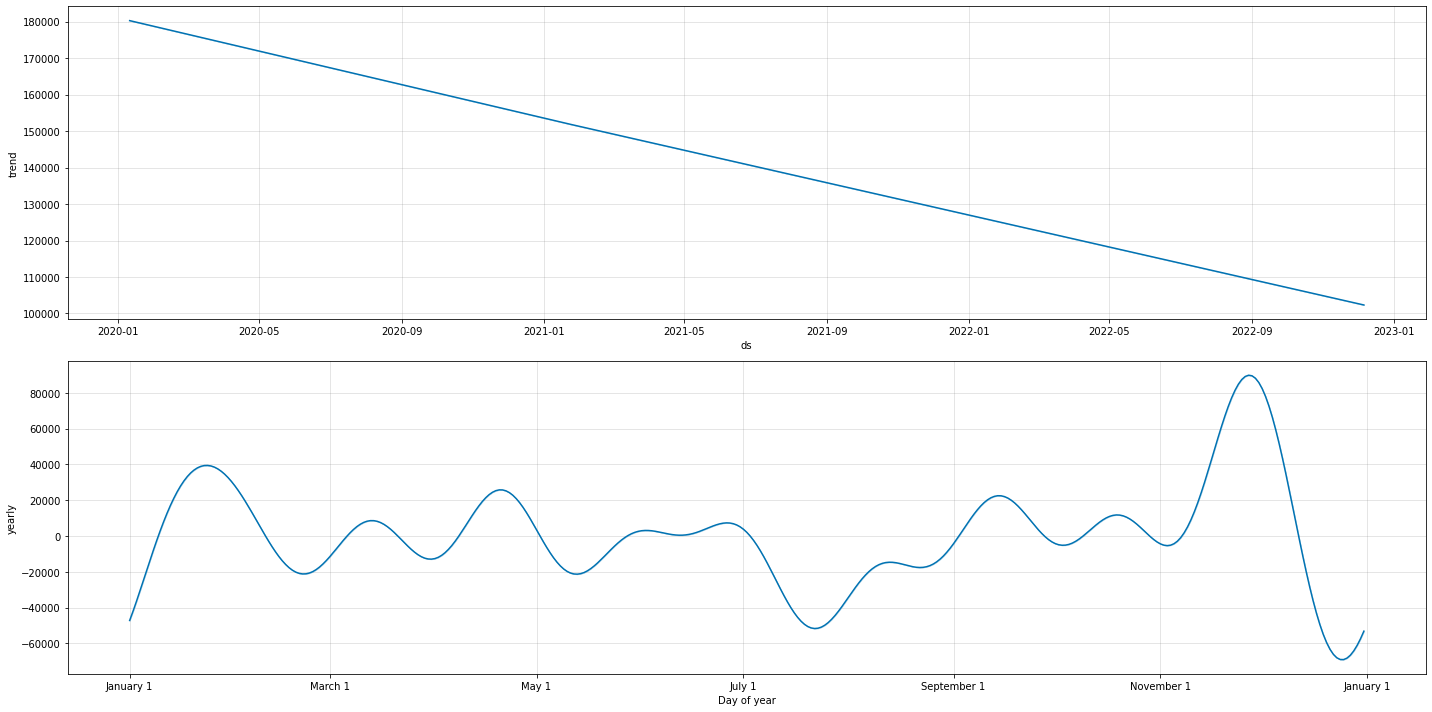

In [ ]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [ ]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)

final_data = data_wdates.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]

In [ ]:
X = final_data.drop(columns=['revenue', 'start_of_week'])
y = final_data['revenue']

# The Model

In [ ]:
#this is an infinite-length function but it slows down the code too much
def carryover_infinite(x, theta):
    x = tt.as_tensor_variable(x)
    #x = tt.vector("x")
    #theta = tt.scalar("theta")

    def carryover_infinite_recurrence(index, input_x, decay_x, theta):
        return tt.set_subtensor(decay_x[index], tt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])

    output, _ = theano.scan(
        fn = carryover_infinite_recurrence, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]

In [ ]:
#Here is a simpler function with finite length as an explicit parameter
def carryover(x, strength, length=14):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([tt.zeros(i),x[:x.shape[0]-i]]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [ ]:
control_variables = ["trend", "season"]
delay_channels = [f'spend_channel_{i}' for i in range(1,8)]
transform_variables = control_variables+delay_channels

y_transformed=y/10000 #rescale target variable

X_transformed = X.copy() #Min-max scale the features

numerical_encoder_dict = {}
for feature in transform_variables:
    scaler = MinMaxScaler()
    original = final_data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    X_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

with pm3.Model() as mmm1:
    channel_contributions = []
    
    for channel in delay_channels:
        print(f"Delay channels: Adding {channel}")
        #Force the channel coefficients to be normal:
        coef = pm3.HalfNormal(f'coef_{channel}', sigma = 2)
        car = pm3.Beta(f'car_{channel}', alpha=2, beta=2)
      
        channel_data = X_transformed[channel].values
        channel_contribution = pm3.Deterministic(
            f'contribution_{channel}',
            coef * carryover(
                    channel_data,
                    car),
            )
        
        channel_contributions.append(channel_contribution)
    
    control_contributions = []
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
  
        x = X_transformed[control_var].values
  
        control_beta = pm3.Normal(f"control_{control_var}", sigma = 3)
        control_x = control_beta * x
        control_contributions.append(control_x)

    base = pm3.Normal("base", np.mean(y_transformed.values), sigma = 2)
    #base = pm3.Exponential('base', lam=0.01)
    noise = pm3.Exponential('noise', lam=0.1)

    sales = pm3.Normal(
        'sales',
        mu= base + sum(control_contributions) + sum(channel_contributions),
        sigma=noise,
        observed=y_transformed
    )

Delay channels: Adding spend_channel_1
Delay channels: Adding spend_channel_2
Delay channels: Adding spend_channel_3
Delay channels: Adding spend_channel_4
Delay channels: Adding spend_channel_5
Delay channels: Adding spend_channel_6
Delay channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season


## Do the prior distributions make sense?

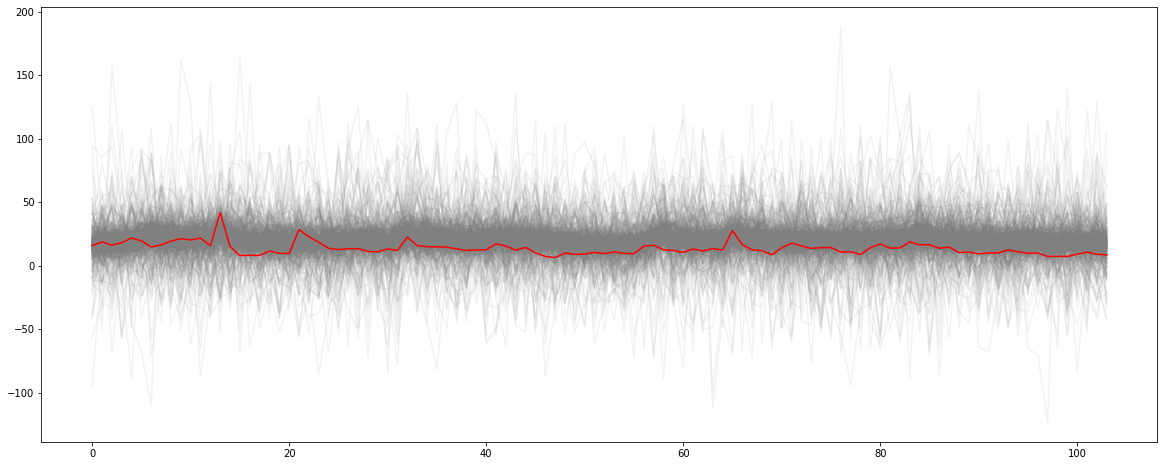

In [ ]:
with mmm1:
    prior_pred = pm3.sample_prior_predictive()
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["sales"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(y_transformed.values, color = "red")

carryover priors: 7
coef priors: 7
control coef priors: 3
sigma prior: 1


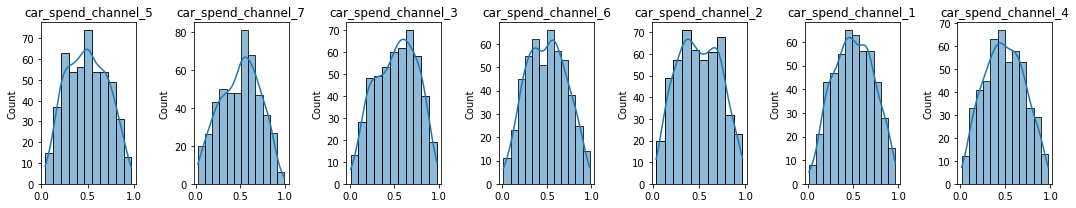

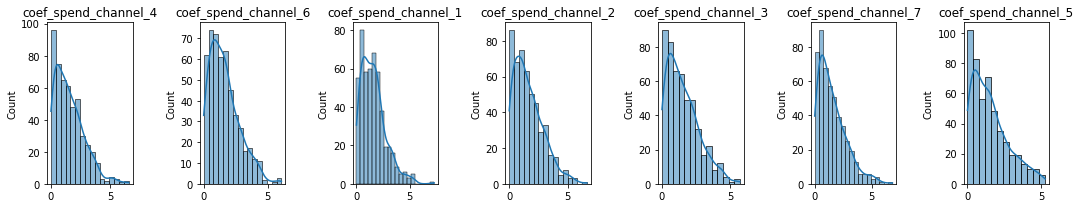

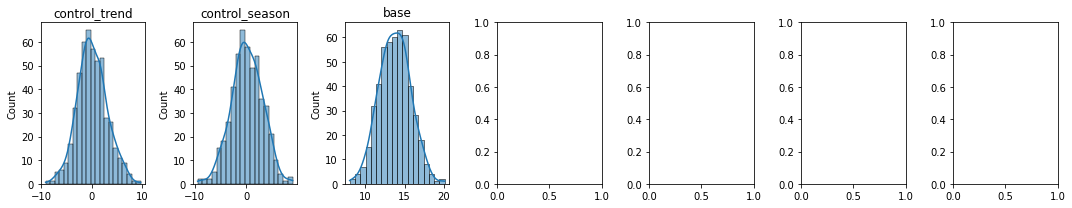

In [ ]:
#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm3.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 7
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm3.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    

adstock_priors = [p for p in prior_names if p.startswith("car")]
plot_priors(adstock_priors, prior_pred)
print(f"carryover priors: {len(adstock_priors)}")

# alpha_priors = [p for p in prior_names if p.startswith("sat")]
# plot_priors(alpha_priors, prior_pred)
# print(f"sat priors: {len(alpha_priors)}")

media_coef_priors = [p for p in prior_names if p.startswith("coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.startswith("control_")] + ["base"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

#plot_priors(["sigma"], prior_pred)

print(f"sigma prior: 1")

## Fit the model

In [ ]:
with mmm1:
  trace = pm3.sample(return_inferencedata=True, tune=3000, target_accept=0.95)
  trace_summary = az.summary(trace)

/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [ ]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
control_trend,2.226,2.019,-1.785,5.763,0.048,0.038,1738.0,1562.0,1.0
control_season,4.750,1.860,1.397,8.340,0.040,0.028,2176.0,1508.0,1.0
base,6.811,1.206,4.585,9.033,0.030,0.021,1646.0,1513.0,1.0
coef_spend_channel_1,0.915,0.777,0.005,2.268,0.017,0.012,1317.0,833.0,1.0
car_spend_channel_1,0.446,0.214,0.063,0.806,0.004,0.003,2634.0,1449.0,1.0
...,...,...,...,...,...,...,...,...,...
contribution_spend_channel_7[100],0.481,0.323,0.000,1.034,0.008,0.006,1404.0,848.0,1.0
contribution_spend_channel_7[101],0.635,0.414,0.000,1.346,0.010,0.007,1376.0,767.0,1.0
contribution_spend_channel_7[102],0.651,0.424,0.001,1.382,0.010,0.007,1388.0,767.0,1.0
contribution_spend_channel_7[103],0.701,0.456,0.000,1.486,0.011,0.008,1385.0,767.0,1.0


# Analysis

## Posterior distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabda7341f0>,
      dtype=object)

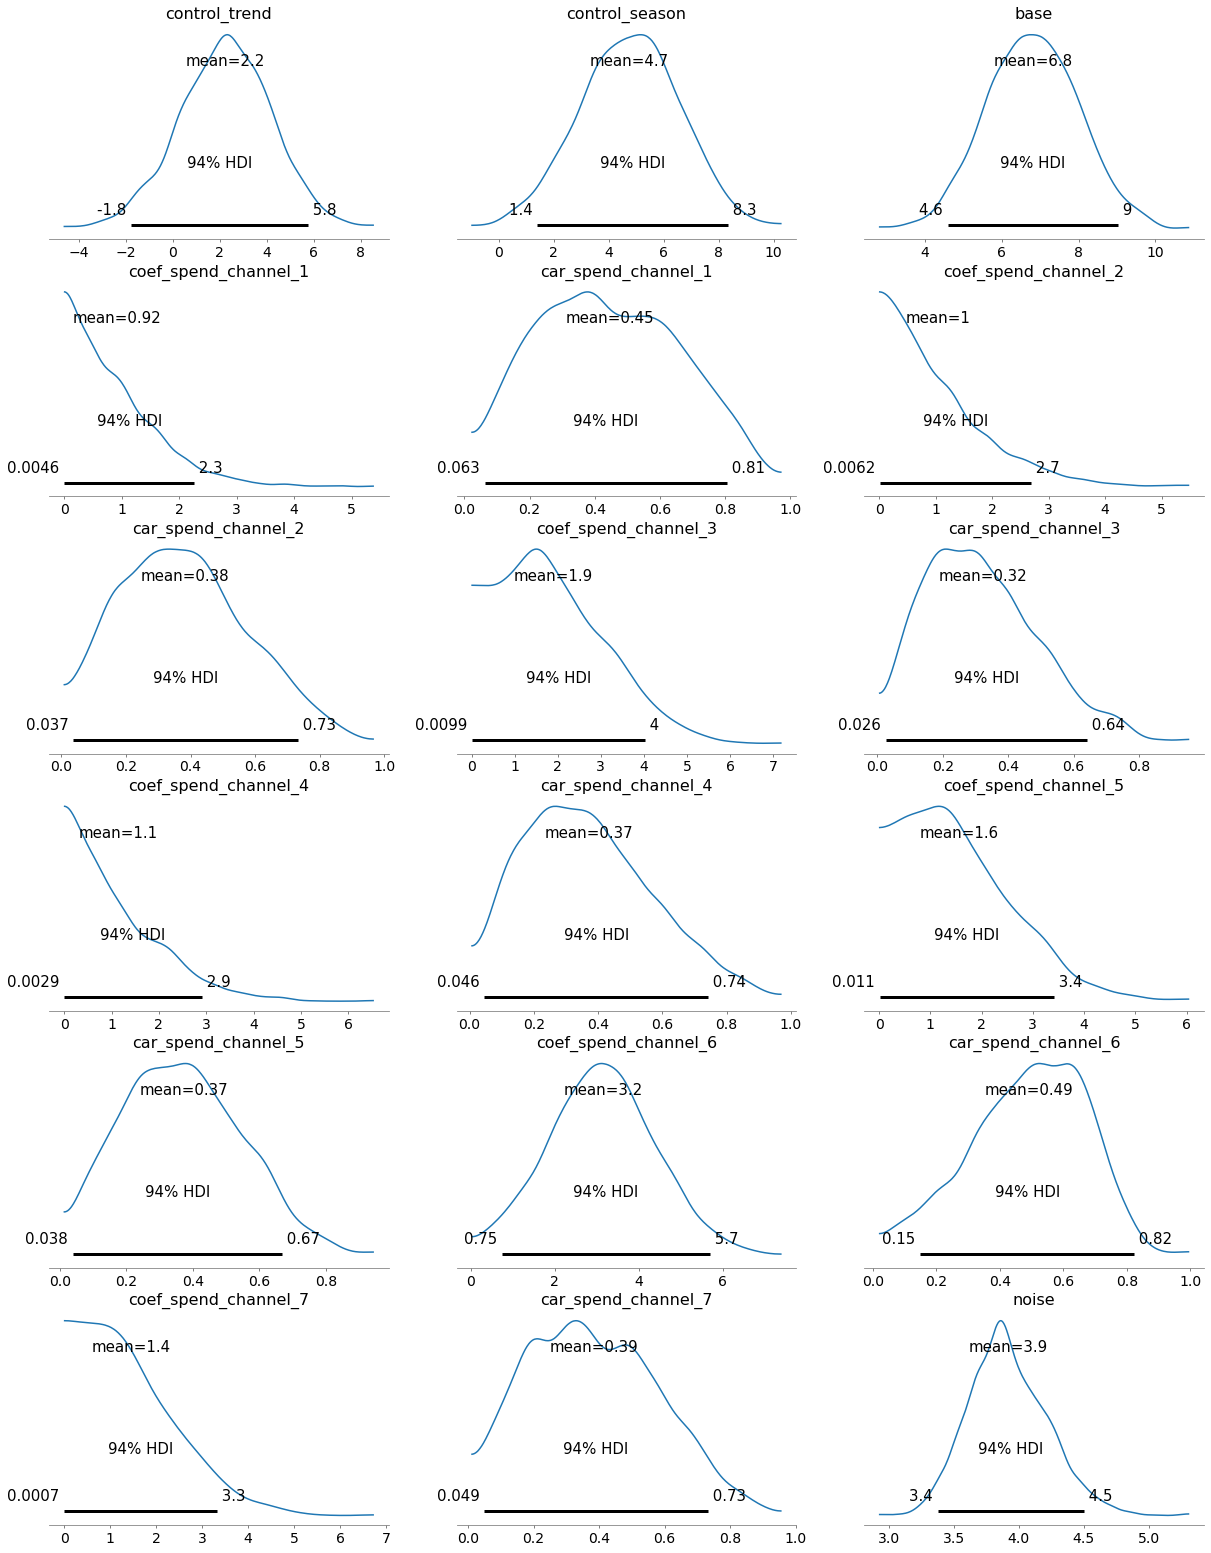

In [ ]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

## Predictions vs Observations

In [ ]:
with mmm1:
    posterior = pm3.sample_posterior_predictive(trace)

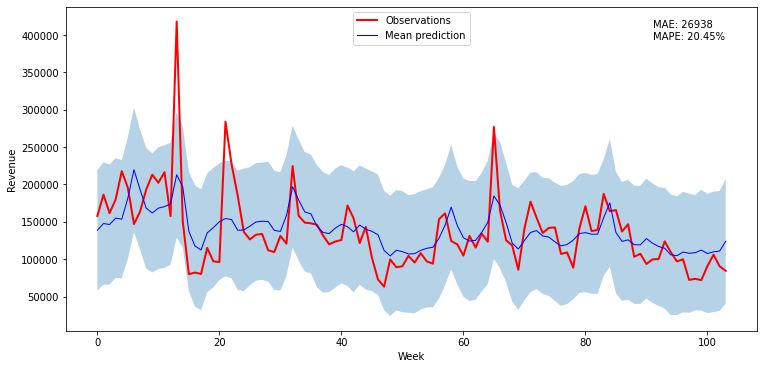

In [ ]:
y_pred = posterior['sales'].mean(0)*10000
y_stds = posterior['sales'].std(0)*10000

MAE = mean_absolute_error(y.values, y_pred)
MAPE = mean_absolute_percentage_error(y.values, y_pred)*100
SkillStr = 'MAE: %5d\nMAPE: %5.2f%%'%(MAE,MAPE)
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.15,
                        bottom=0.15,
                        right=0.95,
                        top=0.9)
ax.plot(y.values, linewidth=2, c='r', label='Observations')
ax.plot(y_pred, linewidth=1, c='b', label='Mean prediction')
ax.fill_between(np.arange(len(y)), y_pred - 2*y_stds, y_pred + 2*y_stds, alpha=0.33)
ax.text(0.85,0.9,SkillStr, transform=ax.transAxes)
ax.legend(loc='upper center')
ax.set_xlabel('Week')
ax.set_ylabel('Revenue')
plt.show()

## Channel Contributions and ROI



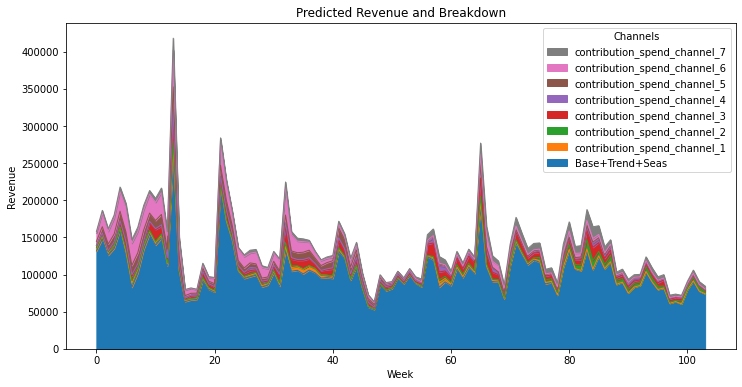

In [ ]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'{channel}']
            .values
            .reshape(2000, 104)
            .mean(0)
           )

channels = [f'contribution_spend_channel_{i}' for i in range(1,8)]

unadj_contributions = pd.DataFrame(
    {'Base+Trend+Seas': trace.posterior['base'].values.mean()
                 +trace.posterior['control_trend'].values.mean()
                 +trace.posterior['control_season'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(12, 6),
          linewidth=1,
          title='Predicted Revenue and Breakdown',
          ylabel='Revenue',
          xlabel='Week'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="upper right",
    #bbox_to_anchor=(1.01, 0.5)
)
plt.show()

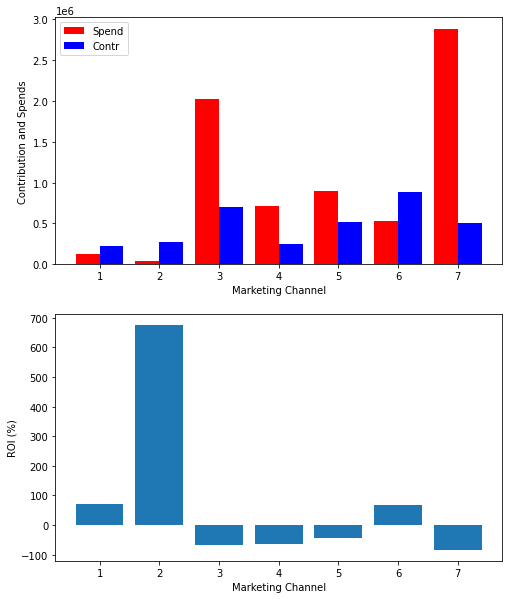

In [ ]:
#Calculate ROI for each channel
total_contr = adj_contributions.sum(axis=0)
total_spend = X.sum(axis=0)

Cchannels = [f'contribution_spend_channel_{i}' for i in range(1,8)]
            
Schannels = [f'spend_channel_{i}' for i in range(1,8)]

ROI_l= [None] * 7
spend_l = [None] * 7
contr_l = [None] * 7
for i in range(7):
    spend_l[i] = total_spend[Schannels[i]]
    contr_l[i] = total_contr[Cchannels[i]]
    ROI_l[i] = (contr_l[i] - spend_l[i])/spend_l[i] *100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.bar(np.arange(1,8) - 0.2, spend_l, color = 'r', width = 0.4, label='Spend')
ax1.bar(np.arange(1,8) + 0.2, contr_l, color = 'b', width = 0.4, label='Contr')
ax1.set_xlabel('Marketing Channel')
ax1.set_ylabel('Contribution and Spends')
ax1.legend(loc='upper left')

ax2.bar(range(1,8),ROI_l)
ax2.set_xlabel('Marketing Channel')
ax2.set_ylabel('ROI (%)')

plt.show()
